# Imports 

In [1]:
!pip install lightning -q

In [1]:
# Herramientas
import os
from tqdm import tqdm
from pathlib import Path

# Manejo de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Lightning
import lightning as L

# Scikit learn
from sklearn import model_selection

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Matplot estilo
plt.style.use('ggplot')

#  Carga de datos 

<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left: 20px">   
Para poder tener acceso a los datos, lo que debemos hacer es permitirle a python poder ubicarlos, para lo cual vamos a utilizar la librería pathlib. Mediante el uso de la clase Path de pathlib, añadimos el path (dirección de ubicación) de los datos, y lo asignamos a una variable que denominamos files_path. Dado que los datasets se encuentran en formato CSV, vamos a utilizar Pandas para leerlos, mas precisamente la función read_csv().

In [3]:
files_path = 'data/mnist'

In [4]:
path = Path(files_path)
os.listdir(path)

['sample_submission.csv', 'mnist_train.csv', 'mnist_test.csv']

In [5]:
train = pd.read_csv(path/'mnist_train.csv')

In [7]:
test = pd.read_csv(path/'mnist_test.csv')

<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left: 20px">   
Una vez cargados los datos podemos valernos de todas las funciones que dispone pandas para analizarlos, mediante .sample() podemos ver un listado random de filas que conforman los datasets. El número 5 es para espedificarle a sample la cantidad de filas o rows que deseamos ver, por defecto este valor es 1.

In [8]:
train.sample(5)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
46302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
26493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
9939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
48249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
28977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7


In [9]:
test.sample(5)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left: 20px">   
Mediante el uso de ".shape" podemos tener un pantallazo general de cuantas filas y columnas hay en los datasets. En este caso, podemos ver que el dataset train, está formado por 56000 filas y 785 columnas, una de las cuales se llama label, que es la variable que se debe predecir, la misma es un dígito que va de 0 a 9. El resto de columnas o features, corresponden a los diferentes píxeles de los dígitos hechos a mano. Cada dígito de dimensiones 28 x 28, estirada en un array de 784 de largo. El dataset de test compuesto por 14000 filas y 784 columnas, los datos de test, no cuentan con la variable label la cual debemos predecir nosotros, y está formada por dígitos del 0 al 9, como vimos con anterioridad. A esto lo podemos ver, gracias a la utilización de otra función de pandas llamada value_counts(), con sort_index() lo que hacemos es que pandas ordene los valores de acuedo a su índice, en este caso label. Por defecto los ordena de acuerdo a la cuenta de los mismos.

In [10]:
train.shape, test.shape

((56000, 785), (14000, 784))

In [11]:
train.label.value_counts().sort_index()

0    5522
1    6302
2    5592
3    5713
4    5459
5    5050
6    5501
7    5834
8    5460
9    5567
Name: label, dtype: int64

# Exploración de datos 

<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left: 20px">   
En este apartado veremos como se forma cada uno de los dígitos y algunas muestras del dataset

In [12]:
def show_digit_random_sample(df):
    """
    Con esta función podremos ver una muestra aleatoria de un dígito del dataset que le pasemos como argumento
    """
    # tomamos un ídice aleatorio con random.randint
    idx = np.random.randint(0, len(df))
    # utilizamos ese índice para filtrar los datos
    img = df.iloc[idx, 1:].values
    # nos quedamos con la label correspondiente
    label = df.loc[idx, 'label']
    # reshape del array al formato 28x28
    img = img.reshape(28, 28)

    # creamos una figura con matplotlib
    fig = plt.figure(figsize = (12,12))
    # añadimos de título la label correspondiente
    plt.title(f'Label = {label}')
    ax = fig.add_subplot(111)
    # creamos una cuadrícula y mostramos el array de imagen en ella
    ax.imshow(img, cmap='Blues_r')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

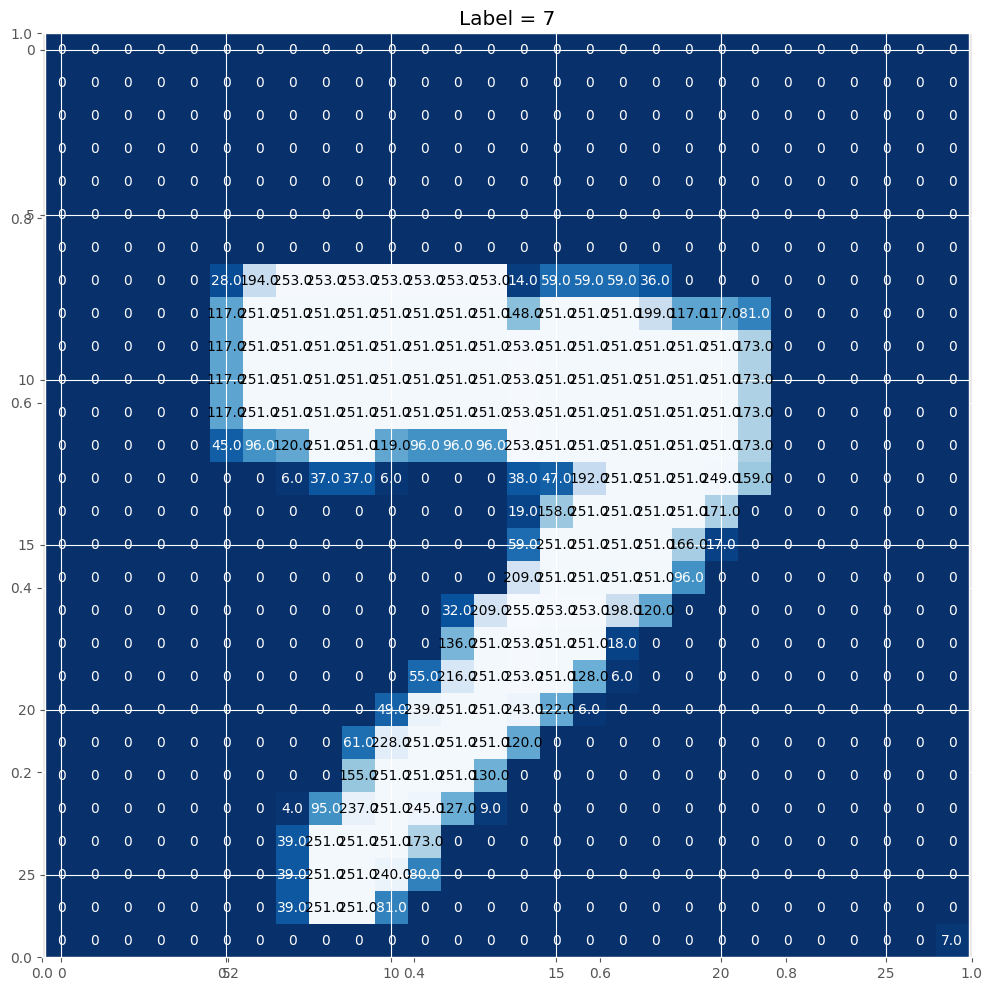

In [15]:
show_digit_random_sample(train)

<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left: 20px">   
Aquí podemos ver en este caso un 7, el cual se forma pintando ciertos pílexes de la cuadrícula que conforman las columnas o features del dataset.

In [16]:
def plot_digits(data, row_size):
    """
    Con esta función podremos ver en una cuadrícula una muestra de algunos dígitos que conforman un dataset 
    """
    # quitamos la columna label si es que está presente
    if data.shape[1] == 785:
        data = data.drop('label', axis=1)
    data = data.to_numpy()[:36]
    # for loop para crear una cuadrícula de shape row_size x row_size
    for i in range(len(data)):
        ax = plt.subplot(row_size, row_size, i+1)
        
        digit = data[i]
        digit_image = digit.reshape(28, 28)
        
        plt.imshow(digit_image, cmap=plt.cm.Blues)
        plt.axis("off")

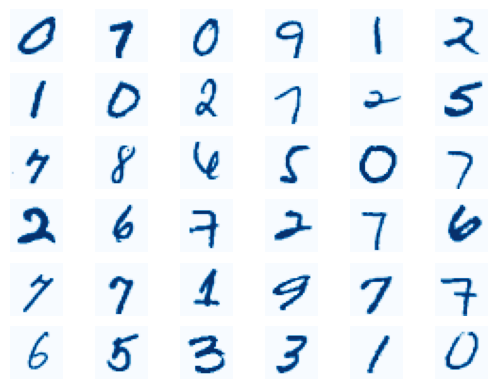

In [17]:
plot_digits(train, row_size=6)

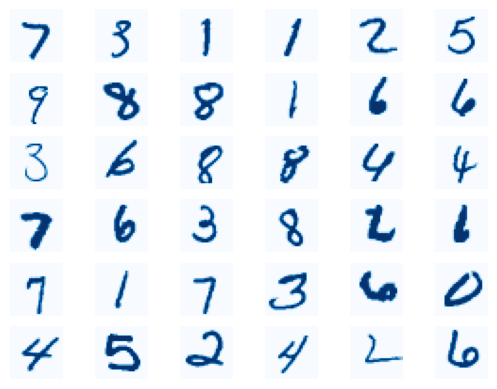

In [18]:
plot_digits(test, row_size=6)

# Entrenamiento 

<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left: 20px">   
Para entrenar utilizaremos una red neuronal básica, llamada perceptrón multicapa, y haremos uso de una serie de librerías de python para entrenar redes neuronales como lo son Pytorch, y Lightning para ahorrarnos un poco de código. Para poder verificar el correcto funcionamiento del entrenamiento, siempre es conveniente separar los datos en 2 partes, la de train, que se usará para entrenar al modelo, y validación, que permitirá evaluar/validar el modelo, para verificar el correcto funcionamiento del train. En este caso dividiremos los datos con la función train_test_split de sklearn, y crearemos un split de validación del 15% de los datos, además nos valdremos de la clase Dataset de Pytorch que nos permitirá crear los datasets, que luego se utilizarán en el entrenamiento.

In [19]:
train_split, valid_split = model_selection.train_test_split(train, test_size=.15, shuffle=True, random_state=42)

In [20]:
train_split = train_split.reset_index(drop=True)
valid_split = valid_split.reset_index(drop=True)

In [21]:
train_split.shape, valid_split.shape

((47600, 785), (8400, 785))

<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left: 20px">   
Como podemos observar el dataset de train se ha dividido en 2 partes, train y validación, con 47600 y 8400 muestras cada uno de ellos. 

<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left: 20px"> 
La clase Dataset de Pytorch necesita contar con 3 métodos o funciones que son, init, len y getitem. Init nos permite inicializar la clase, len conocer el tamaño de dataset, y por último, getitem permite tomar una muestra del dataset. 

In [22]:
class Dataset(Dataset):
    """
    Toma un dataset, lo divide en imágenes, labels y lo convierte a tensores.
    """
    def __init__(self, dataset):      
        self.dataset = dataset
        self.labels = dataset['label'] 
        
    def __len__(self):
        return len(self.dataset) 
      
    def __getitem__(self, idx):
        img = self.dataset.iloc[idx,1:]
        img = torch.tensor(img, dtype=torch.float)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return img, label

In [23]:
train_ds = Dataset(train_split)
valid_ds = Dataset(valid_split)

<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left: 20px">   
A continuación seleccionaremos unos de los hiperparámetros mas importantes de nuetra red, llamado batch size, el cual nos permite dividir los datos en conjuntos mas pequeños llamados batches, para poder calcular los gradientes de una forma mas eficiente. Este hiperparámetro se puede tunnear, en este caso seleccionaremos un batch_size de tamaño 128, lo que quiere decir que dividiremos los datos de train en aproximadamente 370 batches con 128 observaciones o muestras cada uno. Para los datos de validación dado que no es necesario calcular los gradientes, podemos utilizar un batch size mayor. Por último, para hacer mas rápida la carga de los datos a la hora del entrenamiento, utilizaremos una clase de Pytorch llamada DataLoader.

In [24]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [25]:
images, labels = next(iter(train_loader))

In [26]:
images.shape, labels.shape

(torch.Size([128, 784]), torch.Size([128]))

<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left: 20px">
Siempre es bueno chequear que el DataLoader haya sido creado correctamente, en este caso podemos ver que las imágenes tienen una shape de 128 (tamaño del batch) x 784 (columnas de dígitos) y las labels son un array de 128 elementos. Por lo que podemos decir que hemos hecho bien el proceso.

<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left: 20px">   
Por último, crearemos nuestra red neuronal, que como mencionamos previamente, se trata de un perceptrón multicapa. El mismo está compuesto por 2 capas lineales (linear1 y linear2), una función de pérdida (loss_fn), necesaria para optimizar el modelo (CrossEntropyLoss), un optimizador y learning rate, necesarios para actualizar los parámetros de nuestra red haciendo mínimos ajustes luego de cada iteración, y por último, una función de activación, la cual se encarga de definir si se "activa" o no la neurona a la hora del cálculo de los gradientes, de manera de reducir la simplicidad del cómputo de los mismos. En este caso usaremos una denominada ReLU, cuya fórmula es a = max(0, z), la cual básicamente elimina cualquier valor negativo que tome z.

    
 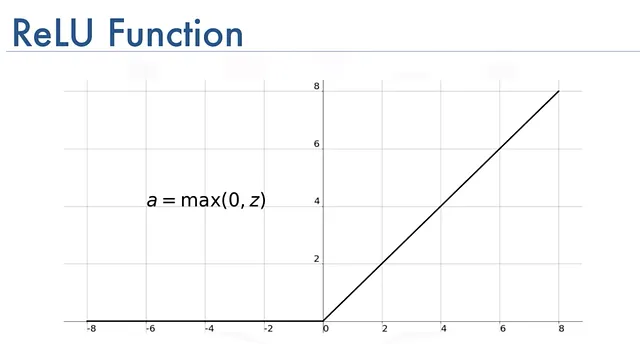

In [27]:
class Module(L.LightningModule):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.metric = lambda y_hat, y: torch.sum(torch.argmax(y_hat, dim=1) == y).item() / y.shape[0]

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, batch):
        out = self.linear1(batch)
        out = F.relu(out)
        out = self.linear2(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.metric(y_hat, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc',self.metric(y_hat, y), prog_bar=True)

In [28]:
input_size = train.iloc[:,1:].shape[1] # El input size son nuestras columnas con dígitos
hidden_size = 128 # hidden size puede ser tomar el valor que querramos
classes = len(train.label.value_counts()) # classes son los dígitos a predecir

module = Module(input_size, hidden_size, classes)

In [29]:
module

Module(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [31]:
trainer = L.Trainer(
    accelerator=device,
    devices=1,
    max_epochs=5,
)

trainer.fit(module, train_loader, valid_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/juan/Desktop/olympo/ipynbs/challenges/mnist/lightning_logs

  | Name    | Type             | Params
---------------------------------------------
0 | linear1 | Linear           | 100 K 
1 | linear2 | Linear           | 1.3 K 
2 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


<p style="font-size:16px; font-family:verdana; line-height: 1.7em; margin-left: 20px">   
Como podemos observar a pesar de que utilizamos una red neuronal muy simple, y sólo la hemos entrenado por 5 epochs, la misma ha sido capaz de predecir los dígitos de validación con una presición del 0.96. Nada mal.

#  Predicciones 

Una vez entrenado el modelo podemos usarlo para generar las predicciones con los datos de test. El formato debe coincidir con el de la `sample_submission.csv`.

In [46]:
sample_submission = pd.read_csv(path/'sample_submission.csv')
sample_submission

,label
0,0
1,0
2,0
3,0
4,0
...,...
13995,0
13996,0
13997,0
13998,0


El índice del `DataFrame` coincide con el de la imagen en los datos de test, y la columna `label` es la predicción del modelo.

In [47]:
test_split = test.copy()

In [48]:
test_split['label'] = 0 # como en test no tenemos una columna label creamos una y le asignamos un valor, 0 en este caso 

In [49]:
test_ds = Dataset(test_split)

In [50]:
test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

In [54]:
def inference(model, device):
    """
    Toma un modelo, permite hacer inferencia con él, devuelve una lista con id y label para cada predicción.
    """
    submission = []
    model.to(device)
    # como estamos por hacer una inferencia, no necesitamos calcular gradientes, lo hacemos con torch.no_grad()
    with torch.no_grad():
        # ponemos al modelo en modo evaluación
        model.eval()
        # for loop para predecir todo el test_dataloader
        for images, _ in tqdm(test_loader):
            logits = model(images.to(device))
            preds = torch.exp(logits)
            top_p, top_class = preds.topk(1, dim=1)

            # appendeo de predicciones a submission con su correcpondiente id
            for prediction in top_class:
                submission.append(prediction.item())
                
    return submission

In [55]:
submission = inference(module, device)

100%|██████████| 55/55 [00:04<00:00, 13.66it/s]


In [56]:
submission_df = pd.DataFrame(submission, columns=['label'])
submission_df

,label
0,7
1,3
2,1
3,1
4,2
...,...
13995,5
13996,2
13997,6
13998,2


In [57]:
submission_df.to_csv('submission.csv', index=False) # exportamos el submission dataframe como csv y nos aseguramos de quitar el índice

El archivo resultante `submission.csv` ya está listo para ser usado en la competición.